# Housing

In [2]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Homeownership rate

In [2]:
# Seasonally adjusted homeownership rate
url = ('https://api.census.gov/data/timeseries/eits/hv?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=yes')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
df = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('VALUE'))
df.to_csv(data_dir / 'homeown.csv', index_label='date', 
          header=True)

In [3]:
df = pd.read_csv(data_dir / 'homeown.csv', 
                 index_col='date', parse_dates=True)['VALUE']
col = 'violet!60!magenta'
node = end_node(df, col, percent=True, 
                date='q', full_year=True)
write_txt(text_dir / 'homeown_node.txt', node)
dtlt = dtxt(df.index[-1])['qtr1']
latest = df.iloc[-1]
ch3yr = value_text(df.diff(12).iloc[-1], ptype='pp', 
                   adj='total')
url = 'https://www.census.gov/housing/hvs/index.html'
cl = c_line(col)
text = (f'As of {dtlt}, the Census Bureau \href{{{url}}}'+
        f'{{report}} a homeownership rate of {latest:.1f} '+
        f'percent {cl}. Over the past three years, the '+
        f'overall US homeownership rate {ch3yr}.')
write_txt(text_dir / 'homeown.txt', text)
print(text)

As of 2022 Q2, the Census Bureau \href{https://www.census.gov/housing/hvs/index.html}{report} a homeownership rate of 65.8 percent (see {\color{violet!60!magenta}\textbf{---}}). Over the past three years, the overall US homeownership rate increased by a total of 1.5 percentage points.


### By Race/Ethnicity

In [4]:
url = 'https://www.census.gov/housing/hvs/data/histtab16.xlsx'

data = pd.read_excel(url)
df = data.iloc[7:-9].reset_index().drop('index', axis=1)
df.columns = ['Date', 'Total', 'White', 'Black', 'Other', 'Other2', 'Hispanic']
df = df.replace('2002r', 2002).replace('20033', 2003).dropna(how='all')

q = {1: '01', 2: '04', 3: '07', 4: '10'}

d = {}
for i, row in df.iterrows():
    if i not in d.keys():
        d[i] = {}
    if type(row['Date']) == int:
        for y in list(range(i, i+5)):
            if y in df.index:
                d[y] = {'quarter': ''}
                d[y]['year'] = row['Date']
    if (type(row['Date']) != int) & ('.' in str(row['Date'])):
        d[i]['quarter'] = q[int(row['Date'][0])]
        
    if 'year' not in d[i].keys():
        d[i] = {'date': '', 'year': '', 'quarter': ''}
    else:
        d[i]['date'] = f'{d[i]["year"]}-{d[i]["quarter"]}-01'
        
dates = {k: v['date'] for k, v in d.items()}
df['date'] = df.index.map(dates)
df = df.dropna()
df = df.set_index(pd.to_datetime(df.date))
result = df[['White', 'Black', 'Hispanic', 'Other', 'Total']]
result.to_csv(data_dir / 'homeown2.csv', index_label='date')

In [5]:
result = pd.read_csv(data_dir / 'homeown2.csv', index_col='date', 
                     parse_dates=True)

color_list = [('Black', 'red!20!orange!95!black'), 
              ('White', 'blue!80!cyan!80!black'),
              ('Hispanic', 'green!80!blue!85!black'),
              ('Other', 'red!80!black')]
cl = {}
for group, color in color_list:
    write_txt(text_dir / f'homeown_{group.lower()}_node.txt', 
              end_node(result[group], color, percent=True))
    cl[group] = c_line(color)

wtlt = result.White.iloc[-1]
blmax = result['Black'].max()
blidxmax = dtxt(result['Black'].idxmax())['qtr2']
blmin = result.loc['2006':, 'Black'].min()
blidxmin = dtxt(result.loc['2006':, 'Black'].idxmin())['qtr1']
bllt = result.Black.iloc[-1]
ltdt = dtxt(result.index[-1])['qtr1']
hsmax = result['Hispanic'].max()
hsidxmax = dtxt(result['Hispanic'].idxmax())['qtr2']
hslt = result['Hispanic'].iloc[-1]
compare = compare_text(hslt, hsmax, [0.3, 1.0, 3.0])
if hslt == hsmax:
    cmp_txt = 'the highest on record'
else:
    cmp_txt = f'{compare} the {hsmax:.1f} percent peak rate in {hsidxmax}'

text = (f'Around three-quarters ({wtlt:.1f} percent in {ltdt}) of '+
        f'non-Hispanic white households own their home {cl["White"]}, '+
        'compared to fewer than half of black and Hispanic households. ')
write_txt(text_dir / 'homeown2.txt', text)
print(text, '\n')

txt2 = ('During the housing bubble, the homeownership rate for black '+
        'households increased by nearly ten percentage points, peaked  '+
        f'at {blmax:.1f} percent in {blidxmax}, and fell to {blmin:.1f} '+
        f'percent in {blidxmin}. The current homeownership rate for black '+
        f'households is {bllt:.1f} percent, as of {ltdt} {cl["Black"]}. '+
        f'The rate for Hispanic households of any race is {hslt:.1f} '+
        f'percent in {ltdt}, {cmp_txt} {cl["Hispanic"]}. ')
write_txt(text_dir / 'homeown3.txt', txt2)
print(txt2)

Around three-quarters (74.6 percent in 2022 Q2) of non-Hispanic white households own their home (see {\color{blue!80!cyan!80!black}\textbf{---}}), compared to fewer than half of black and Hispanic households.  

During the housing bubble, the homeownership rate for black households increased by nearly ten percentage points, peaked  at 49.7 percent in the second quarter of 2004, and fell to 40.6 percent in 2019 Q2. The current homeownership rate for black households is 45.3 percent, as of 2022 Q2 (see {\color{red!20!orange!95!black}\textbf{---}}). The rate for Hispanic households of any race is 48.3 percent in 2022 Q2, far below the 51.4 percent peak rate in the second quarter of 2020 (see {\color{green!80!blue!85!black}\textbf{---}}). 


### FHFA Housing Price Index

In [6]:
url = ('https://www.fhfa.gov/DataTools/Downloads/'+
       'Documents/HPI/HPI_PO_monthly_hist.xls')
df = pd.read_excel(url, header=3, index_col=0, 
                   parse_dates=True).iloc[1:]
sa = df[[col for col in df.columns if 'NSA' not in col]]
sa.columns = [col.replace('\n(SA)', '').replace('\n', '') 
              for col in df.columns if 'NSA' not in col]
sa.to_csv(data_dir / 'hpi_raw.csv', index_label='date')

In [7]:
dr = pd.read_csv(data_dir / 'hpi_raw.csv', index_col='date', 
                 parse_dates=True)
data = (dr.pct_change(12) * 100)
data['USA3M'] = m3rate(dr.USA)
df = data.loc['1991':, ['USA', 'USA3M']]
df.to_csv(data_dir / 'hpi.csv', index_label='date', float_format='%g')

adj = node_adj(df)
smax = df.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

colors = {'USA': 'purple!90!black', 'USA3M': 'blue!35!cyan'}

node_file = open(text_dir / 'hpi_nodes.txt', 'w')
for series, color in colors.items():
    date = 'm' if series == smax else None
    node_file.write(end_node(df[series], color, date=date,
                             percent=True, full_year=True,
                             size=1.1, offset=adj[series]))
node_file.close()

ch = data['USA']
chtxt = value_text(df.USA.iloc[-1])
prtxt = value_text(df.USA.iloc[-2], 'increase_of')
ltdt = dtxt(df.USA.index[-1])['mon1']
prdt = dtxt(df.USA.index[-2])['mon1']
pr = df.USA.iloc[-2]
pr3 = df.USA3M.iloc[-2]
regions = data.drop(['USA', 'USA3M'], axis=1).iloc[-1]
div = regions.idxmax()
maxval = regions.max()
divs = pd.read_csv('raw/census_regions.csv')
div_list = divs[divs['Division'] == div].State.to_list()
states = f"{', '.join(div_list[:-1])}, and {div_list[-1]}"
ch3m = df.USA3M.iloc[-1]
mreg = value_text(maxval)
text = (f'{chtxt} over the year ending {ltdt} {c_line(colors["USA"])}. '+
        'The average of the latest three months of data compared '+
        f'to the previous three months shows an annualized growth '+
        f'rate of {ch3m:.1f} percent {c_line(colors["USA3M"])}. '+
        f'In {prdt}, the one-year growth rate was {pr:.1f} percent '+
        f'and the three-month growth rate was {pr3:.1f} percent. '+
        f'Home prices in the {div} region, which includes {states}, '+
        f'{mreg} in {ltdt}, the highest one-year growth rate.')
write_txt(text_dir / 'fhfa.txt', text)
print(text)

increased 13.9 percent over the year ending July 2022 (see {\color{purple!90!black}\textbf{---}}). The average of the latest three months of data compared to the previous three months shows an annualized growth rate of 10.9 percent (see {\color{blue!35!cyan}\textbf{---}}). In June 2022, the one-year growth rate was 16.3 percent and the three-month growth rate was 17.5 percent. Home prices in the South Atlantic region, which includes the District of Columbia, Delaware, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, and West Virginia, increased 18.9 percent in July 2022, the highest one-year growth rate.


In [8]:
t = pd.DataFrame()
for i in [-1, -2, -3, -4, -13, -25, -37]:
    t[dtxt(data.index[i])['mon6']] = data.iloc[i]
    
t['`03--`05 Average'] = data.loc['2003':'2005'].mean()
t['`09--`12 Average'] = data.loc['2009':'2012'].mean()

final = (t.rename({'USA': '\\textbf{United States}'})
          .drop('USA3M')
          .sort_values(dtxt(data.index[-1])['mon6'], ascending=False)
          .round(1))

final.to_csv(data_dir / 'hpi.tex', sep='&', line_terminator='\\\ ', 
             quotechar=' ')
final

,Jul `22,Jun `22,May `22,Apr `22,Jul `21,Jul `20,Jul `19,`03--`05 Average,`09--`12 Average
South Atlantic,18.9,22.0,23.9,23.9,20.6,7.4,5.0,11.3,-3.7
East South Central,16.4,18.6,19.5,19.5,18.3,7.7,6.0,5.1,-1.6
Mountain,15.1,18.1,22.7,23.5,25.4,8.6,7.2,11.0,-4.2
West South Central,14.8,17.5,19.7,19.1,17.9,5.7,4.3,4.3,0.3
\textbf{United States},13.9,16.3,18.4,19.0,19.3,7.0,5.0,9.2,-2.5
Middle Atlantic,12.0,14.2,14.0,14.4,18.0,6.4,3.8,11.3,-2.3
East North Central,11.9,12.9,15.1,15.2,16.4,7.1,5.4,4.3,-2.4
New England,11.6,14.2,16.9,17.7,21.1,7.3,4.5,10.3,-2.2
West North Central,11.3,12.4,14.5,15.9,15.9,6.7,4.2,5.4,-1.2
Pacific,10.0,13.4,16.0,19.0,21.9,6.8,4.7,18.4,-3.9


### Ratio of price to rent

In [9]:
hpi = pd.read_csv(data_dir / 'hpi_raw.csv', index_col='date', 
                  parse_dates=True)['USA']
rent = (pd.read_csv(data_dir / 'cpi_raw.csv', index_col='date', 
                    parse_dates=True)['Rent of primary residence'])
ratio = (hpi / rent).dropna()
ratio = ratio / ratio.iloc[0]
ratio.name = 'VALUE'
ratio.to_csv(data_dir / 'hpi_rent_ratio.csv', index_label='date', 
             header=True)

ltdate = dtxt(ratio.index[-1])['mon1']
ltval = (ratio.iloc[-1] - 1) * 100
cl = c_line('red')
val = value_text(ltval, 'above_below')
text = (f'As of {ltdate}, housing prices are {val} '+
        f'the rental equivalent {cl}.')
write_txt(text_dir / 'hp_rent.txt', text)
print(text)

As of July 2022, housing prices are 50.6 percent above the rental equivalent (see {\color{red}\textbf{---}}).


### Owner's equity share in real estate

In [10]:
data = fred_df('HOEREPHRE')['VALUE'].astype('float')
data.to_csv(data_dir / 'homeeq.csv', index_label='date', header=True)

datelt = dtxt(data.index[-1])['qtr1']
latest = data.iloc[-1]
ch3, ch1 = [value_text(data.diff(i).iloc[-1], style='increase_by', 
                   adj='total', ptype='pp') for i in [12, 4]]
avg89 = data.loc['1989'].mean()
compare = compare_text(latest, avg89, [0.05, 1.0, 5.0])
node_color = 'blue!80!violet'
node = end_node(data, node_color, percent=True, date='q', full_year=True, offset=-0.35)
write_txt(text_dir / 'homeeq_node.txt', node)
cl = c_line(node_color)
url = 'https://www.federalreserve.gov/releases/z1/20191212/html/b101.htm'
text = (f'As of {datelt}, the Federal Reserve \href{{{url}}}{{report}} '+
        f"\\textbf{{owners\' equity}} is {latest:.1f} percent of residential "+
        f"real estate {cl}. Over the past three years, the owners\' "+
        f"equity share {ch3}. Over the past year, the share {ch1}. "+
        f'The current share is {compare} the 1989 average of {avg89:.1f} '+
        f'percent.')
write_txt(text_dir / 'homeeq.txt', text)
print(text)

As of 2022 Q2, the Federal Reserve \href{https://www.federalreserve.gov/releases/z1/20191212/html/b101.htm}{report} \textbf{owners' equity} is 70.5 percent of residential real estate (see {\color{blue!80!violet}\textbf{---}}). Over the past three years, the owners' equity share increased by a total of 5.6 percentage points. Over the past year, the share increased by a total of 2.2 percentage points. The current share is substantially above the 1989 average of 67.9 percent.


### Residential construction

In [11]:
key = census_key
base = 'https://api.census.gov/data/timeseries/eits/resconst'
param = 'cell_value,time_slot_id,category_code,data_type_code'
t = '&time=from+1989'
oth = '&for=us&seasonally_adj=yes'

url = f'{base}?get={param}&key={key}{t}{oth}'

r = requests.get(url).json()

In [12]:
for t in ['total', 'single', 'multi']:
    df = pd.DataFrame()
    for series in ['APERMITS', 'ASTARTS', 'ACOMPLETIONS']:
        df[series] = pd.Series(
            {pd.to_datetime(i[4]): 
             float(i[0]) for i in r[1:] if i[2] == series 
             and i[3] == t.upper()}
        ).sort_index()
    df.to_csv(data_dir / f'permits_{t}.csv', index_label='date')

In [13]:
df = pd.read_csv(data_dir / 'permits_total.csv', 
                 parse_dates=True, index_col='date')
p_col = 'blue!70!green'
node = end_node(df.APERMITS, p_col, date='m', full_year=True, 
                digits='comma', offset=0.35)
write_txt(text_dir / 'permits_node.txt', node)
c_col = 'blue!30!cyan'
node = end_node(df.ACOMPLETIONS, c_col, date='m', full_year=True, 
                digits='comma', offset=0.35)
write_txt(text_dir / 'completions_node.txt', node)

s = series_info(df['APERMITS'])
s['val_5yr_ago'] = df['APERMITS'].iloc[-61]

if s['days_since_match'] > 100:
    hlt = f", {s['last_matched']}"
else:
    hlt = ''
month = s['date_latest'].strftime('%B')

d = {}
for i in ['val_prev', 'val_year_ago', 'val_5yr_ago']:
    mo_ch = s["val_latest"] - s[i]
    mo_pch = (s["val_latest"] / s[i] - 1) * 100
    if mo_ch >= 0.1:
        txt = f'increased by {abs(mo_ch)*1000:,.0f} ({mo_pch:.1f} percent)'
    elif mo_ch <= -0.1:
        txt = f'decreased by {abs(mo_ch)*1000:,.0f} ({mo_pch:.1f} percent)'
    else:
        txt = 'were virtually unchanged' 
    d[i] = txt

date = s["date_latest_ft"]    
    
text = (f'In {date}, a seasonally-adjusted annual rate of '+
        f'{s["val_latest"]*1000:,.0f} new residential housing '+
        f'units were authorized by building permits{hlt} '+
        f'{c_line(p_col)}. Permits issued {d["val_prev"]} '+
        f'(annualized) over the previous month, {d["val_year_ago"]} '+
        f'over last {month}, and {d["val_5yr_ago"]} total '+
        f'over the past five years.')
write_txt(text_dir / 'permits.txt', text)
print(text, '\n')

prdate = dtxt(df.index[-2])['mon3']
pryrdate = dtxt(df.index[-13])['mon1']
ltval = df['ACOMPLETIONS'].iloc[-1]
prval = df['ACOMPLETIONS'].iloc[-2]
pryrval = df['ACOMPLETIONS'].iloc[-3]
text = (f'In {date}, a seasonally-adjusted annual rate of '+
        f'{ltval*1000:,.0f} new residential units were completed '+
        f'{c_line(c_col)}, compared to {prval*1000:,.0f} in '+
        f'{prdate} and {pryrval*1000:,.0f} in {pryrdate}.')
write_txt(text_dir / 'completions.txt', text)
print(text)

In August 2022, a seasonally-adjusted annual rate of 1,542,000 new residential housing units were authorized by building permits, the lowest level since August 2020 (see {\color{blue!70!green}\textbf{---}}). Permits issued decreased by 143,000 (-8.5 percent) (annualized) over the previous month, decreased by 230,000 (-13.0 percent) over last August, and increased by 220,000 (16.6 percent) total over the past five years. 

In August 2022, a seasonally-adjusted annual rate of 1,342,000 new residential units were completed (see {\color{blue!30!cyan}\textbf{---}}), compared to 1,419,000 in July and 1,391,000 in August 2021.


In [14]:
for t in ['single', 'multi']:
    df = pd.read_csv(data_dir / f'permits_{t}.csv', 
                     parse_dates=True, index_col='date')
    date = dtxt(df.index[-1])['mon1']
    pval = df['APERMITS'].iloc[-1]
    cval = df['ACOMPLETIONS'].iloc[-1]
    text = (f'In {date}, a seasonally-adjusted annual rate of '+
            f'{pval*1000:,.0f} new {t}-family residential units were '+
            f'permitted and {cval*1000:,.0f} were completed.')
    write_txt(text_dir / f'permits_{t}.txt', text)
    print(text)

In August 2022, a seasonally-adjusted annual rate of 900,000 new single-family residential units were permitted and 1,017,000 were completed.
In August 2022, a seasonally-adjusted annual rate of 595,000 new multi-family residential units were permitted and 318,000 were completed.


### Residential Construction by Region, Index

In [15]:
url = 'https://www.census.gov/construction/bps/permitsbyusreg_cust.xls'
df = pd.read_excel(url, sheet_name='Units SA', usecols='B,G,I,K,M', 
                   header=4, skipfooter=5, index_col=0, parse_dates=True)
df.iloc[1:].to_csv(data_dir / f'permits_region.csv', index_label='date')

In [16]:
df = pd.read_csv(data_dir / 'permits_region.csv', 
                 parse_dates=True, index_col='date')

In [17]:
df

,Northeast,Midwest,South,West
date,,,,
1996-01-01,97,313,610,367
1996-02-01,116,318,615,371
1996-03-01,137,335,596,369
1996-04-01,145,333,636,349
1996-05-01,139,314,663,341
...,...,...,...,...
2022-04-01,163,250,989,421
2022-05-01,128,230,941,396
2022-06-01,151,198,922,425


<AxesSubplot:xlabel='date'>

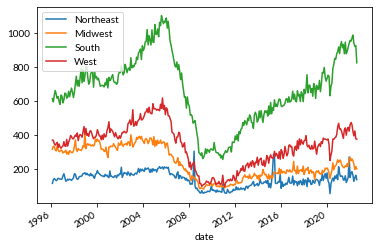

In [18]:
df.iloc[1:].plot()

### Household formation estimates

In [19]:
# Retrieve historical data and revised data
files = {'hist': 'histtab8.xlsx',
         'rev': 'hist_tab_8a_v2020.xlsx'}
url = 'https://www.census.gov/housing/hvs/data/'
for name, file in files.items():
    data = pd.read_excel(url + file).iloc[4:, :5]
    data.columns = ['category', 'Q1', 'Q2', 'Q3', 'Q4']
    years = []
    for h in data[data['Q1'] == '1st Qtr'].index - 1:
        year_raw = data.loc[h, 'Q1']
        if type(year_raw) == int:
            year = year_raw
        elif type(year_raw) == str:
            year = int(year_raw[:4])
        elif type(year) == float:
            year = year + 1
        years.append(year)
    data.loc[data['Q1'] == '1st Qtr', 'category'] = years
    data = data.dropna(subset=['category'])
    
    levels = pd.DataFrame()
    for series in ['Owner', 'Renter', 'Vacant']:
        srs = data.loc[data['category'].astype('str')
                       .str.contains(series)]
        srs.index = years
        srs = srs[['Q1', 'Q2', 'Q3', 'Q4']].unstack().swaplevel()
        srs.index = pd.to_datetime([f'{i[0]}-{i[1]}' 
                                    for i in srs.index])
        srs = srs.sort_index()
        levels[series] = srs
    res = levels[~levels.index.duplicated()]
    res.to_csv(data_dir / f'hhform_raw_{name}.csv', 
               index_label='date')

In [20]:
hist = pd.read_csv(data_dir / 'hhform_raw_hist.csv', index_col='date', 
                    parse_dates=True)
rev = pd.read_csv(data_dir / 'hhform_raw_rev.csv', index_col='date', 
                    parse_dates=True)
level = pd.concat([hist.loc[:'2000'], rev.loc['2001':]])
level['Occupied'] = level[['Owner', 'Renter']].sum(axis=1)
cats = ['Owner', 'Renter', 'Vacant']
lvl = (level[cats + ['Occupied']].rolling(4).mean() / 1_000).loc['1989':].dropna()
lvl.to_csv(data_dir / 'hhform_lvl.csv', 
                        index_label='date')
cols = {'Owner': 'teal!68!green!95!black', 'Renter': 'cyan!65!white', 
        'Vacant': 'orange!80!yellow'}
offsets = node_adj(lvl)
nodes = '\n'.join([end_node(lvl[cname], color, offset=offsets[cname]) 
                   for cname, color in cols.items()])
write_txt(text_dir / 'hhform_lvl_nodes.txt', nodes)
level['Total'] = level.sum(axis=1)
level['pop'] = nipa_df(retrieve_table('T70100')['Data'], ['B230RC'])
res = (level.divide(level['pop'], axis=0)[cats]
            .rolling(4).mean().dropna()) * 100
res = res.loc['1989':]
res = res - res.iloc[0]
res.to_csv(data_dir / 'hhform_idx.csv', index_label='date')
offsets = node_adj(res)
nodes = '\n'.join([end_node(res[cname], color, offset=offsets[cname]) 
                   for cname, color in cols.items()])
write_txt(text_dir / 'hhform_idx_nodes.txt', nodes)

ltdt = dtxt(level.dropna().index[-1])['qtr1']
lvllt = lvl['Occupied'].iloc[-1]
lvlltr = lvl['Renter'].iloc[-1] 
lvllto = lvl['Owner'].iloc[-1]
lvl90 = lvl.loc['1990-10-01', 'Occupied']
shltr = (lvl['Renter'] / lvl['Occupied']).iloc[-1] * 100
shlto = (lvl['Owner'] / lvl['Occupied']).iloc[-1] * 100
htxt = (f'Over the year ending {ltdt}, there were an average of {lvllt:.1f} '+
        f'million households, compared to {lvl90:.1f} million in 1990.')
write_txt(text_dir / 'hh_tot.txt', htxt)

text = (f'Over the year ending {ltdt}, there were an average of '+
        f'{lvllt:.1f} million total occupied '+
        f'housing units in the US, of which {lvlltr:.1f} million '+
        f'({shltr:.1f} percent) were rented, and {lvllto:.1f} '+
        f'million ({shlto:.1f} percent) were owner-occupied. ')
write_txt(text_dir / 'hhform_lvl.txt', text)
print(text)

Over the year ending 2022 Q1, there were an average of 127.0 million total occupied housing units in the US, of which 43.9 million (34.6 percent) were rented, and 83.1 million (65.4 percent) were owner-occupied. 


In [21]:
cats = ['Owner', 'Renter', 'Vacant']
occ = 'Occupied'

grps = {}
for name, dft in {'hist': hist, 'rev': rev}.items():
    dft['Occupied'] = dft[['Owner', 'Renter']].sum(axis=1)
    grps[name] = growth_contrib_ann(dft[cats + [occ]], 'Occupied')[cats].dropna()
    
ch = pd.concat([grps['hist'].loc[:'2001'], grps['rev'].loc['2002':]])
ch = ch.loc['1987':].rolling(4).mean().dropna()
ch['pop'] = (nipa_df(retrieve_table('T70100')['Data'], ['B230RC'])
                .pct_change(4).dropna() * 100).round(2)
ch.dropna().to_csv(data_dir / 'hhform.csv', index_label='date')

ch['Occupied'] = ch['Owner'] + ch['Renter']
ch19 = ch.loc['2019-10-01':, 'Occupied'].mean()
chpop = ch.loc['2019-10-01':, 'pop'].mean()
ch19oo = value_text(ch.loc['2019-10-01':, 'Owner'].mean(), 
           'contribution', 'pp', adj='average')
ch19r = value_text(ch.loc['2019-10-01':, 'Renter'].mean(), 
           'contribution', 'pp')
chlt = ch['Occupied'].iloc[-1]
chltoo = value_text(ch['Owner'].iloc[-1], 'contribution', 'pp')
chltr = value_text(ch['Renter'].iloc[-1], 'contribution', 'pp')
text = (f'From 2019 Q4 to {ltdt}, the average annual \\textbf{{household '+
        f'formation rate}} was {ch19:.1f} percent, while annual population '+
        f'growth averaged {chpop:.1f} percent. Changes in the number '+
        f'of owner-occupied households {ch19oo} {c_box(cols["Owner"])}, and '+
        f'changes in rented households {ch19r} {c_box(cols["Renter"])}. Over '+
        f'the year ending {ltdt}, the household formation rate averaged '+
        f'{chlt:.1f} percent, of which owner-occupied households {chltoo}, '+
        f'and rented households {chltr}. ')
write_txt(text_dir / 'hhform.txt', text)
print(text)

From 2019 Q4 to 2022 Q1, the average annual \textbf{household formation rate} was 1.5 percent, while annual population growth averaged 0.3 percent. Changes in the number of owner-occupied households contributed 1.5 percentage points on an average basis (see\cbox{teal!68!green!95!black}), and changes in rented households contributed 0.0 percentage point (see\cbox{cyan!65!white}). Over the year ending 2022 Q1, the household formation rate averaged 0.6 percent, of which owner-occupied households subtracted 0.9 percentage point, and rented households contributed 1.5 percentage points. 


### New Home Sales

In [22]:
# New home sales data from Census API
url = ('https://api.census.gov/data/timeseries/eits/ressales?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=yes&data_type_code=TOTAL'+
       '&category_code=ASOLD')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
df = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('VALUE'))
df.to_csv(data_dir / 'nhs.csv', index_label='date', 
          header=True)

In [23]:
data = pd.read_csv(data_dir / 'nhs.csv', index_col='date',
                   parse_dates=True)['VALUE']
node_color = 'green!80!blue'
datelt = dtxt(data.index[-1])['mon1']
latest = data.iloc[-1] * 1000
ch1yr = data.pct_change(12).iloc[-1]

txt = value_text(ch1yr)
compdt = '2020-02-01'
cdt = dtxt(pd.to_datetime(compdt))['mon1']
pc = data.loc[compdt]
pcch = ((data.iloc[-1] / pc) - 1) * 100
pcvt = value_text(pcch)
url = 'https://www.census.gov/construction/nrs/pdf/newressales.pdf'
cl = c_line(node_color)
text = (f'In {datelt}, seasonally-adjusted \\textbf{{annualized sales}} '+
        f'of new single-family home sales were {latest:,.0f} {cl}, '+
        f'as \href{{{url}}}{{reported}} by the Census Bureau. '
        f'Over the past year, new homes sales {txt}. Pre-COVID, '+
        f'in {cdt}, the annualized rate of '+
        f'single family new home sales was {pc * 1000:,.0f}. '+
        f'Since {cdt}, new home sales have {pcvt}.')
write_txt(text_dir / 'nhs.txt', text)
print(text)

node = end_node(data, node_color, date='m', digits=0, full_year=True)
write_txt(text_dir / 'nhs_node.txt', node)

In August 2022, seasonally-adjusted \textbf{annualized sales} of new single-family home sales were 685,000 (see {\color{green!80!blue}\textbf{---}}), as \href{https://www.census.gov/construction/nrs/pdf/newressales.pdf}{reported} by the Census Bureau. Over the past year, new homes sales decreased 0.0 percent. Pre-COVID, in February 2020, the annualized rate of single family new home sales was 690,000. Since February 2020, new home sales have decreased 0.7 percent.


### Months' Supply

In [24]:
# New home inventory, levels
url = ('https://api.census.gov/data/timeseries/eits/ressales?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=yes&data_type_code=TOTAL'+
       '&category_code=FORSALE')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
df = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('VALUE'))
df.to_csv(data_dir / 'nhs_foresale.csv', index_label='date', 
          header=True)

In [25]:
# Months Supply from Census API
url = ('https://api.census.gov/data/timeseries/eits/ressales?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=yes&data_type_code=MONSUP'+
       '&category_code=FORSALE')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
df = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('VALUE'))
df.to_csv(data_dir / 'nhs_s.csv', index_label='date', 
          header=True)

In [26]:
# Inventory levels text
data = pd.read_csv(data_dir / 'nhs_foresale.csv', index_col='date',
                   parse_dates=True)['VALUE']
ltval = data.iloc[-1] * 1000
chval = data.diff(12).iloc[-1] * 1000
chtxt = value_text(chval, 'increase_of', digits=0, ptype=None, threshold=1000)
ltdt = dtxt(data.index[-1])['mon1']
prdt = dtxt(data.index[-13])['mon1']
value_text(chval, 'increase_of', digits=0, ptype=None, threshold=1000)
url = 'https://www.census.gov/construction/nrs/index.html'
txt1 = ('The \\textbf{inventory} of new homes for sale affects housing prices. '+
       f'The Census Bureau \href{{{url}}}{{report}} a seasonally-adjusted '+
       f'total of {ltval:,.0f} new houses for sale in {ltdt}, '+
       f'{chtxt} since {prdt}. ')

# Months supply text
df = pd.read_csv(data_dir / 'nhs_s.csv', index_col='date',
                 parse_dates=True)['VALUE']
# Node
node_color = 'red!90!black'
cl = c_line(node_color)
node = end_node(df, node_color, date='m', digits=1, full_year=True)
write_txt(text_dir / 'nhs_s_node.txt', node)

ltval = df.iloc[-1]
prval = df.iloc[-13]
ltavg = df.mean()
thresh = (1, 2, 4)
ctlt = compare_text(ltval, ltavg, thresh)
ctpr = ctlt = compare_text(ltval, prval, thresh)
lttxt = f'the long-term average supply of {ltavg:.1f} months'
prtxt = f'the year-prior supply of {prval} months'
ctxt = f'{ctpr} {prtxt} and {ctlt} {lttxt}'
if ctlt == ctpr: 
    ctxt = f'{ctlt} both {prtxt} and {lttxt}'
txt2 = (f'At the current pace of new home sales, it would take {ltval} '+
        f'months to exhaust the supply of unsold homes {cl}. Current inventory '+
        f'levels are {ctxt}. ')
text = f'{txt1} {txt2}'
write_txt(text_dir / 'nhs_s.txt', text)
print(text)

The \textbf{inventory} of new homes for sale affects housing prices. The Census Bureau \href{https://www.census.gov/construction/nrs/index.html}{report} a seasonally-adjusted total of 461,000 new houses for sale in August 2022, an increase of 87,000 since August 2021.  At the current pace of new home sales, it would take 8.1 months to exhaust the supply of unsold homes (see {\color{red!90!black}\textbf{---}}). Current inventory levels are slightly above both the year-prior supply of 6.5 months and the long-term average supply of 5.8 months. 


### New Home Sales Price

In [27]:
# New home sales data from Census API
url = ('https://api.census.gov/data/timeseries/eits/ressales?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=no&data_type_code=MEDIAN'+
       '&category_code=SOLD')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
md = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('MEDIAN'))

url = ('https://api.census.gov/data/timeseries/eits/ressales?'+
       f'get=cell_value,time_slot_id,data_type_code,'+
       f'category_code&key={census_key}&time=from+1989&'+
       'for=us&seasonally_adj=no&data_type_code=AVERAG'+
       '&category_code=SOLD')
r = requests.get(url).json()
date = lambda x: pd.to_datetime(x.time)
mn = (pd.DataFrame(r[1:], columns=r[0]).assign(date = date)
        .set_index('date')['cell_value'].astype('float')
        .sort_index().rename('AVERAGE'))

df = pd.concat([mn, md], axis=1)
df.to_csv(data_dir / 'nhs_p.csv', index_label='date', 
          header=True)
p = pd.read_csv(data_dir / 'cpi_raw.csv', index_col='date', 
                parse_dates=True)['All items']
res = (df.multiply(p.loc[df.index[-1]] / p, axis=0)).dropna()
# Save latest date as text 
write_txt(text_dir / 'nhs_p_dt.txt', dtxt(res.index[-1])['mon1'])
res.divide(1000).to_csv(data_dir / 'nhs_rp.csv', index_label='date', 
          header=True)

In [28]:
res = pd.read_csv(data_dir / 'nhs_rp.csv', index_col='date', 
                  parse_dates=True).multiply(1000)

ltdt = dtxt(df.index[-1])['mon1']
mdval = res['MEDIAN'].iloc[-1]
mnval = res['AVERAGE'].iloc[-1]
md1yr = value_text(res.MEDIAN.pct_change(12).iloc[-1] * 100)
md3yr = value_text(res.MEDIAN.pct_change(36).iloc[-1] * 100)
tot = value_text(((res.MEDIAN / res.MEDIAN.iloc[0]) - 1).iloc[-1] * 100)
col = 'violet'
node = end_node(res.MEDIAN / 1000, col, date='m', digits=0, 
                full_year=True, dollar='thousands')
write_txt(text_dir / 'nhs_rp_node.txt', node)
text = ('The Census Bureau also tracks the \\textbf{sales price} of new single-family '+
        f'homes. In {ltdt}, the median new home sold for \${mdval:,.0f} '+
        f'{c_line(col)}, and the average sales price was \${mnval:,.0f}. '+
        'Adjusted for inflation by the CPI, the real median sales price has '+
        f'{md1yr} over the past year, and {md3yr} over the past three '+
        'years. Since 1989, the inflation-adjsted median new home sales '+
        f'price {tot}.')
write_txt(text_dir / 'nhs_rp.txt', text)
print(text)

The Census Bureau also tracks the \textbf{sales price} of new single-family homes. In August 2022, the median new home sold for \$436,800 (see {\color{violet}\textbf{---}}), and the average sales price was \$521,800. Adjusted for inflation by the CPI, the real median sales price has decreased 0.2 percent over the past year, and increased 15.7 percent over the past three years. Since 1989, the inflation-adjsted median new home sales price increased 58.1 percent.


### Mortgage Rate

In [29]:
url = 'https://www.freddiemac.com/pmms/docs/historicalweeklydata.xls'
storage_options = {'User-Agent': 'Mozilla/5.0'}
h = pd.read_excel(url, sheet_name='Full History', 
                  usecols=[0, 1], index_col=0, header=6,
                  storage_options=storage_options, 
                  parse_dates=True)
lt = pd.read_excel(url, usecols=[0, 1], index_col=0, header=6,
                  storage_options=storage_options, 
                  parse_dates=True)
df = pd.concat([h, lt.dropna()])
df.loc['1989':].to_csv(data_dir / 'mortgage.csv', index_label='date')

In [30]:
df = pd.read_csv(data_dir / 'mortgage.csv', index_col='date', 
                 parse_dates=True)
ltdt = dtxt(df.index[-1])['day1']
prdt = dtxt(df.index[-13])['day1']
yrdt = dtxt(df.index[-53])['day1']
ltval = df.FRM.iloc[-1]
prval = df.FRM.iloc[-13]
yrval = df.FRM.iloc[-53]
val19 = df.loc['2019', 'FRM'].mean()
color = 'blue'
cl = c_line(color)

text = (f'As of {ltdt}, the average rate on a 30-year mortgage '+
        f'was {ltval} percent, compared to {prval} percent on '+
        f'{prdt}, and {yrval} percent on {yrdt} {cl}. In 2019, '+
        f'the average rate was {val19:.1f} percent.')
write_txt(text_dir / 'mortgage.txt', text)
print(text)

node = end_node(df['FRM'], color, date='d', percent=True, 
                full_year=True, digits=2)
write_txt(text_dir / 'mortgage_node.txt', node)

As of October 6, 2022, the average rate on a 30-year mortgage was 6.66 percent, compared to 5.51 percent on July 14, 2022, and 2.99 percent on October 7, 2021 (see {\color{blue}\textbf{---}}). In 2019, the average rate was 3.9 percent.


### New Home Affordability

In [26]:
# Wages
columns = ['MONTH', 'YEAR', 'AGE', 'PWORWGT', 'WKEARN', 'WORKFT']
dfc = (pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
                    .query('WKEARN > 0 and WORKFT == 1')
                  for year in range(1989, 2023)]))
w = dfc.groupby(['YEAR', 'MONTH']).apply(binned_wage, percentile=0.5).rename('All')
w.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in w.index]
w = w * 52 / 12

# Median new home sales price
p = pd.read_csv(data_dir / 'nhs_p.csv', index_col='date', 
                  parse_dates=True).MEDIAN

# Mortgage rate
i = pd.read_csv(data_dir / 'mortgage.csv', index_col='date', 
                  parse_dates=True).FRM
ct = i.resample('MS').count()
indx = ct[ct > 3].index
i = i.resample('MS').mean().loc[indx] / 1200

# New Home Affordability
payment = ((p * 0.9) * (i / (1 - ((1 / (1 + i)**360))))).dropna()
nha = ((w / (payment * 3.33)) * 100).dropna()
nha.rename('VALUE').to_csv(data_dir / 'nha.csv', index_label='date', 
          header=True)

In [27]:
color = 'blue!80!black'

node = end_node(nha, color, date='m')
write_txt(text_dir / 'nha_node.txt', node)

value = payment.iloc[-1]
ltdt = dtxt(payment.index[-1])['mon1']
val3m = payment.iloc[-3:].mean()
val19 = payment.loc['2019'].mean()

text = ('The monthly payment associated with new single-'+
        'family home sales typically reflects both the sales '+
        'price and the current mortgage interest rate. The '+
        'monthly principal and interest payment for a 30-year '+
        'fixed-rate mortgage on the median new home sold is '+
        f'\${value:,.0f}, as of of {ltdt}, compared to an '+
        f'average of \${val3m:,.0f} over the past three months, '+
        f'and an average of \${val19:,.0f} in 2019.')
write_txt(text_dir / 'nha_payment.txt', text)
print(text)

cl = c_line(color)
txt2 = ('The affordability of a new house depends on both '+
        "the monthly payment and people's ability to make "+
        'the payment, usually determined by their income. '+
        'New homes are affordable when the monthly payment '+
        'is a third of income, or less.\n\nThe new house affordability '+
        f'index {cl} compares the monthly payment with one-third of '+
        'the median full-time wage. The median full-time wage '+
        'is sufficient to afford the median new home when index '+
        'values are 100 or greater.')
write_txt(text_dir / 'nha2.txt', txt2)
print(txt2)

The monthly payment associated with new single-family home sales typically reflects both the sales price and the current mortgage interest rate. The monthly principal and interest payment for a 30-year fixed-rate mortgage on the median new home sold is \$2,164, as of of August 2022, compared to an average of \$2,239 over the past three months, and an average of \$1,361 in 2019.
The affordability of a new house depends on both the monthly payment and people's ability to make the payment, usually determined by their income. New homes are affordable when the monthly payment is a third of income, or less.

The new house affordability index (see {\color{blue!80!black}\textbf{---}}) compares the monthly payment with one-third of the median full-time wage. The median full-time wage is sufficient to afford the median new home when index values are 100 or greater.


In [88]:
res = pd.concat([nha, payment, p, i * 1200, w], axis=1)
tab = res.iloc[-4:].iloc[::-1].T
tab.columns = tab.columns.strftime('%b `%y')
pryr = res.dropna().iloc[-13]
tab[dtxt(pryr.name)['mon6']] = pryr
tab['2019'] = res.loc['2019'].mean()
tab = tab.T
fmts = {0: '{:.1f}'.format,
        1: '{:,.0f}'.format,
        'FRM': '{:.2f}'.format,
        'MEDIAN': '{:,.0f}'.format,
        'All': '{:,.0f}'.format}
for name, fmt in fmts.items():
    tab[name] = tab[name].apply(fmt)
names = {0: 'Affordability Index', 1: '\hspace{2mm} Monthly Payment (\$)', 
         'MEDIAN': '\hspace{4mm} Median Home Price (\$)', 'FRM': '\hspace{4mm} Mortgage Rate (\%)',  
         'All': '\hspace{2mm} Median Monthly Earnings (\$)'}
tab = tab.rename(names, axis=1).T.replace('nan', '--')
tab.to_csv(data_dir / 'nha.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

In [86]:
tab

,Sep `22,Aug `22,Jul `22,Jun `22,Aug `21,2019
Affordability Index,--,64.0,58.1,61.1,85.0,87.6
\hspace{2mm} Monthly Payment (\$),--,"2,164","2,360","2,194","1,503","1,361"
\hspace{4mm} Median Home Price (\$),--,"436,800","466,300","428,300","404,300","319,267"
\hspace{4mm} Mortgage Rate (\%),6.11,5.22,5.41,5.52,2.84,3.93
\hspace{2mm} Median Monthly Earnings (\$),--,"4,610","4,568","4,467","4,258","3,964"
